In [1]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn import cluster, datasets, mixture

In [3]:
noisy_moons = datasets.make_moons(n_samples=10000, noise=.05)[0].astype(np.float32)

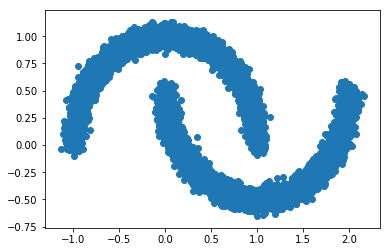

In [4]:
scatter(noisy_moons[:,0], noisy_moons[:,1])

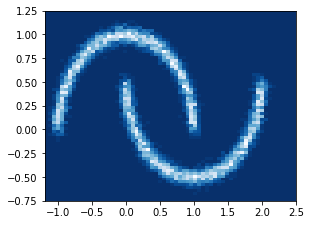

In [5]:
figure(figsize=(4.5,3.5),frameon = False)
var = 0.0
hist2d(noisy_moons[:,0]+var*randn(len(noisy_moons)),
       noisy_moons[:,1] +var*randn(len(noisy_moons)),64,vmax=30,range=[[-1.2,2.5],[-0.75,1.25]],cmap='Blues_r',vmin=0);

#title('Target distribution')

## Defining the model

In [7]:
tf.reset_default_graph()
chain = [ tfp.bijectors.MaskedAutoregressiveFlow(
                                shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[256,256],
                                                                                              activation=tf.nn.relu)),
             tfb.Permute([1,0]),
              tfp.bijectors.MaskedAutoregressiveFlow(
                                shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[256,256],
                                                                                            activation=tf.nn.relu)),

              tfb.Permute([1,0]),
              tfp.bijectors.MaskedAutoregressiveFlow(
                                shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[256,256],
                                                                                              activation=tf.nn.relu)),
              tfb.Permute([1,0]),
              tfp.bijectors.MaskedAutoregressiveFlow(
                                shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_layers=[256,256],
                                                                                              activation=tf.nn.relu)),
            ]
bij = tfb.Chain(chain)

prior  = tfd.MultivariateNormalDiag(loc=tf.zeros(2), scale_identity_multiplier=1.0)
distribution = tfd.TransformedDistribution(prior, bijector=bij)

batch_size = 1024

x = tf.placeholder(tf.float32, shape=(batch_size,2))
lr = tf.placeholder_with_default(0.001, shape=())

samples = distribution.sample(1024)

In [8]:
loss = - tf.reduce_mean(distribution.log_prob(x))

In [9]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
opt_op = optimizer.apply_gradients(zip(gradients, variables))

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
losses = []

In [12]:
for i in range(5000):
    ims = datasets.make_moons(n_samples=batch_size, noise=.05)[0].astype(np.float32)
    _, l = sess.run([opt_op, loss], feed_dict={x:ims, lr:0.001})
    losses.append(l)
    if i %100 ==0:
        print(i, l)

0 2.5004575
100 1.2176721
200 1.0478456
300 0.9397077
400 0.9053507
500 0.73758733
600 0.6174265
700 0.45460063
800 0.4119888
900 0.37870595
1000 0.40177792
1100 0.3713568
1200 0.36701703
1300 0.38807112
1400 0.30291432
1500 0.36934796
1600 0.37220186
1700 0.33526826
1800 0.36631888
1900 0.31445888
2000 0.3202982
2100 0.32834184
2200 0.31082082
2300 0.36339545
2400 0.34629798
2500 0.33349305
2600 0.37887412
2700 0.32228673
2800 0.34096754
2900 0.32953107
3000 0.3682657
3100 0.3815129
3200 0.35489264
3300 0.29621136
3400 0.29865658
3500 0.3268651
3600 0.29591867
3700 0.3591588
3800 0.29723486
3900 0.38986647
4000 0.3001726
4100 0.3021211
4200 0.3334922
4300 0.35037926
4400 0.3168343
4500 0.2921561
4600 0.27443007
4700 0.31313765
4800 0.35056987
4900 0.37458453


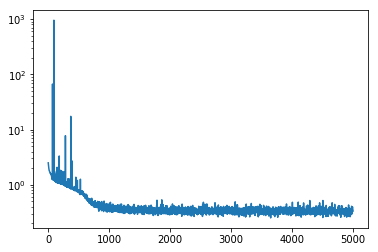

In [13]:
plot(losses)
yscale('log')

In [14]:
fake = sess.run(distribution.sample(10000))

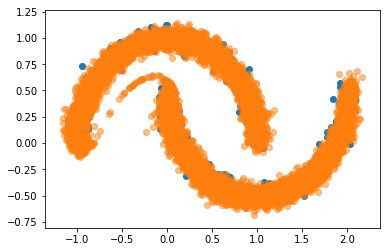

In [15]:
scatter(noisy_moons[:1024,0], noisy_moons[:1024,1])
scatter(fake[:,0], fake[:,1],alpha=0.5)

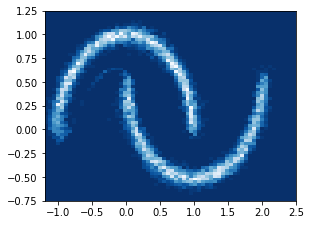

In [16]:
figure(figsize=(4.5,3.5),frameon = False)
hist2d(fake[:,0], fake[:,1],64,vmax=30,range=[[-1.2,2.5],[-0.75,1.25]],cmap='Blues_r',vmin=0);


(-1.2, 2.25)

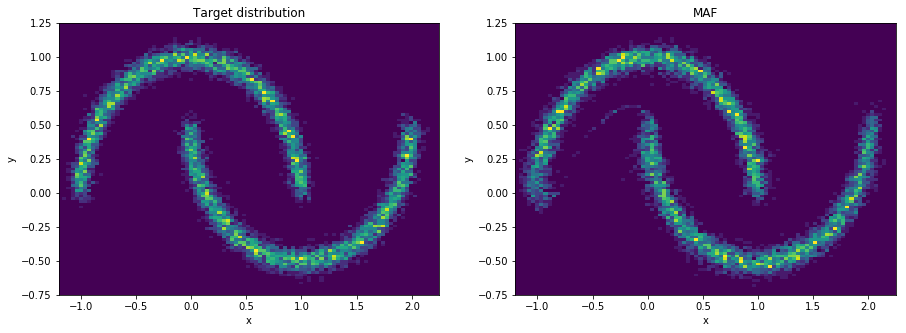

In [17]:
figure(figsize=(15,5))

subplot(121)
var = 0.0
hist2d(noisy_moons[:,0]+var*randn(len(noisy_moons)),
       noisy_moons[:,1] +var*randn(len(noisy_moons)),100,vmax=15,range=[[-1.2,2.5],[-0.75,1.25]]);
xlabel('x')
ylabel('y')
title('Target distribution')

xlim(-1.2,2.25)
xlim(-1.2,2.25)

subplot(122)
hist2d(fake[:,0], fake[:,1],100,vmax=15,range=[[-1.2,2.5],[-0.75,1.25]]);
xlabel('x')
ylabel('y')
title('MAF')
xlim(-1.2,2.25)
xlim(-1.2,2.25)